In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = pd.read_csv("../data/deponieanlieferungen-tufentobel.csv", delimiter=';')

#Check for missing values
missing_values = df.isna().sum()
missing_values

#missing values are in column "Kanton" with only 94 values missing
#also, the there are no relevant outliers in these 94 values
df[df['Kanton'].isna()].describe()

#drop missing values for Kanton
df.dropna(subset=['Kanton'], inplace=True)

#check where the anlieferungen are zero tons
df[df['Gewicht in Tonnen'] == 0].value_counts().sum()

#remove these values
df.drop(df[df['Gewicht in Tonnen'] == 0].index, inplace=True)

#test if it worked
df[df['Gewicht in Tonnen'] == 0].value_counts().sum()

#check very small values
#print(df[df['Gewicht in Tonnen'] < 0.1].value_counts().sum())

#check duplicates
duplicates = df.duplicated()
#print(f"Number of duplicate rows: {duplicates.sum()}")

# #Visualize the outliers in a plot
# plt.figure(figsize=(10, 6))
# plt.boxplot(df['Gewicht in Tonnen'], vert=False)
# plt.title('Boxplot of Gewicht in Tonnen')
# plt.xlabel('Gewicht in Tonnen')
# plt.show()

# df[df['Gewicht in Tonnen'] > 35]

#there is one outlier with 56.7 tons, the other values dont go over 35 tons
#remove this outlier
df.drop(df[df['Gewicht in Tonnen'] > 50].index, inplace=True)

#Time series decomposition

# Convert the date column to datetime
df['Anlieferungsdatum'] = pd.to_datetime(df['Anlieferungsdatum'], utc=True)

# # Set the date column as the index
# df.set_index('Anlieferungsdatum', inplace=True)

df = df[["Anlieferungsdatum", "Material", "Gewicht in Tonnen"]]

In [3]:
# filter for one kind of material, here: Inertstoffe
df = df[df["Material"] == "Inertstoffe"]
# drop the material column
df = df.drop(columns=["Material"])
# group by date and sum the weights
df = df.resample('D', on='Anlieferungsdatum').sum()

In [4]:
# Resample the data to daily frequency
daily_data = df['Gewicht in Tonnen'].resample('D').sum()

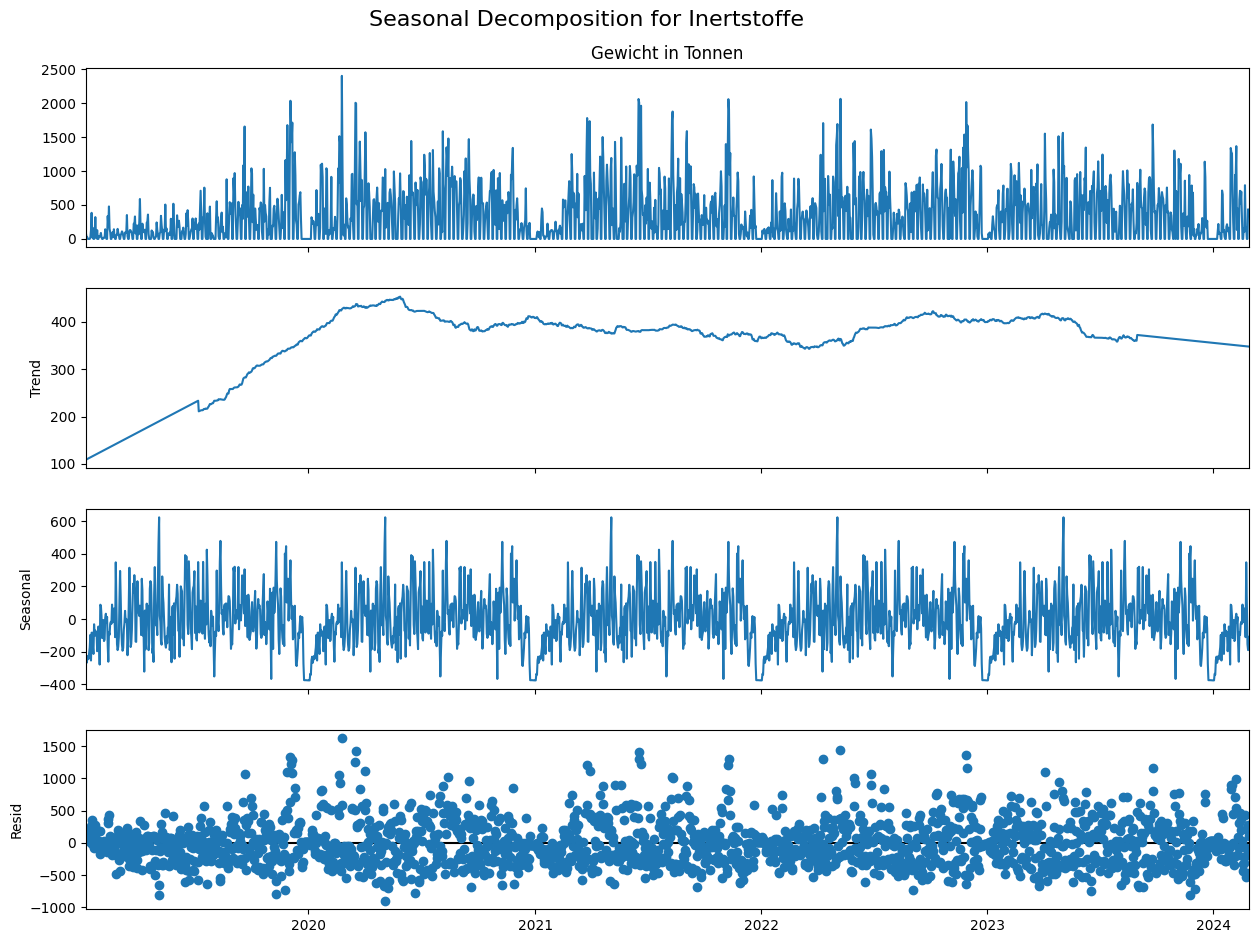

In [5]:

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data, model='additive', period=365, extrapolate_trend='freq')

# Plot the decomposition
# Extract trend and seasonal components
trend = decomposition.trend
seasonal = decomposition.seasonal

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Seasonal Decomposition for Inertstoffe', fontsize=16)
plt.show()

Decomposition

In [6]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(daily_data)

# Extract and print the test statistic and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print("Critical Values:", adf_result[4])

ADF Statistic: -6.105898153722116
p-value: 9.58681827917579e-08
Critical Values: {'1%': np.float64(-3.4338839352172137), '5%': np.float64(-2.8631010343251675), '10%': np.float64(-2.5676010393524713)}


The ADF Statistic 
−
6.1059
−6.1059 is more negative than the critical values at all levels (1%, 5%, 10%).
The p-value is much smaller than 
0.05
0.05, providing strong evidence to reject the null hypothesis.
Conclusion:
The time series is stationary at all commonly used significance levels.

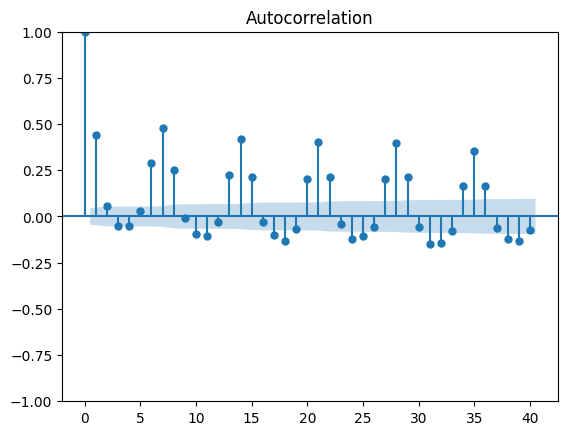

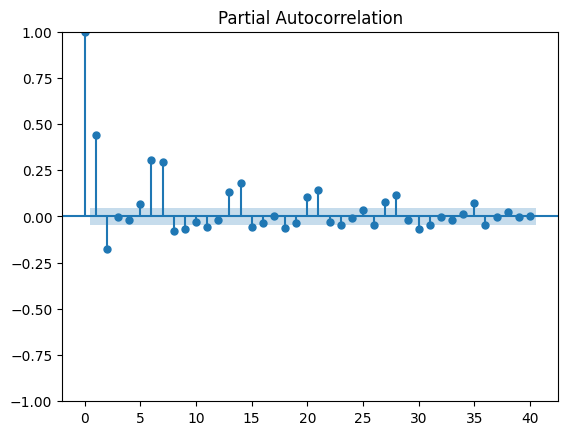

In [7]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(daily_data, lags=40)
plot_pacf(daily_data, lags=40)
plt.show()


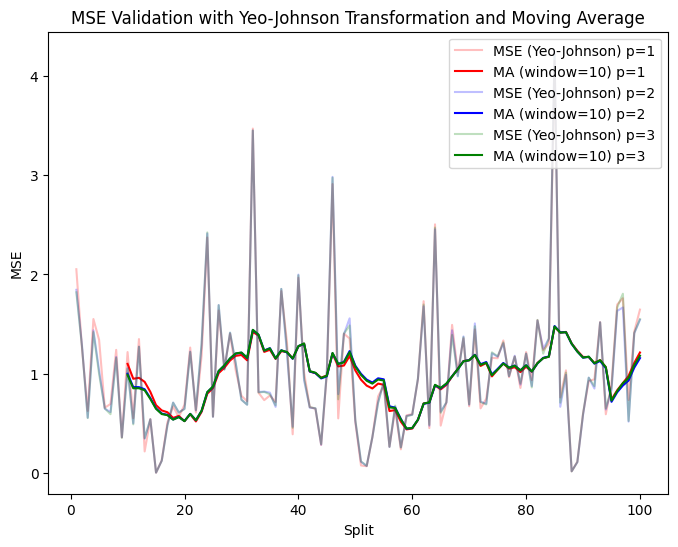

In [10]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load Data ---
# Example: daily_data = pd.Series(...) (Your time series)

# --- 2. Extract Seasonality and Trend ---
# Additive decomposition
# decomposition = sm.tsa.seasonal_decompose(daily_data, model='additive', period=365, extrapolate_trend='freq')
# trend = decomposition.trend
# seasonal = decomposition.seasonal

# --- 3. ARIMA Parameters ---
p, d, q = 1, 0, 1

# --- 4. Data Splitting ---
test_size = 300  # Size of the independent test set
validate_size = 10  # Size of each validation split
train_validate_size = len(daily_data) - test_size  # Remaining data for train and validation

# Split data
train_validate_data = daily_data[:train_validate_size]
test_data = daily_data[train_validate_size:]
trend_train_validate = trend[:train_validate_size]
trend_test = trend[train_validate_size:]
seasonal_train_validate = seasonal[:train_validate_size]
seasonal_test = seasonal[train_validate_size:]

# --- 5. Rolling Validation ---
n_splits = 100
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=validate_size)

# Initialize Yeo-Johnson transformer
yeo_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

# Error lists
colors = ["red", "blue", "green", "orange"]

plt.figure(figsize=(8, 6))
for p in range(1, 4):
    validate_errors = []
    standardized_validate_errors = []
    # --- 6. Training and Validation ---
    for i, (train_index, validate_index) in enumerate(tscv.split(train_validate_data)):
        # Create train and validation splits
        train, validate = train_validate_data.iloc[train_index], train_validate_data.iloc[validate_index]
        trend_train, trend_validate = trend_train_validate.iloc[train_index], trend_train_validate.iloc[validate_index]
        seasonal_train, seasonal_validate = seasonal_train_validate.iloc[train_index], seasonal_train_validate.iloc[validate_index]
        
        # TRAINING
        # Detrend and deseasonalize
        train_residual = train - trend_train - seasonal_train
        # Apply Yeo-Johnson transformation
        train_transformed = yeo_transformer.fit_transform(train_residual.values.reshape(-1, 1)).flatten()
        
        # VALIDATION
        # Detrend and deseasonalize
        validate_residual = validate - trend_validate - seasonal_validate
        # Apply the Yeo-Johnson transformation (using training parameters)
        validate_transformed = yeo_transformer.transform(validate_residual.values.reshape(-1, 1)).flatten()

        # Fit ARIMA model on transformed training split
        model = ARIMA(train_transformed, order=(p, d, q))
        model_fit = model.fit()
        
        # Forecast on validation split
        forecast_transformed = model_fit.forecast(steps=len(validate_transformed))

        # Validation error (Yeo-Johnson transformed scale)
        standardized_error = mean_squared_error(validate_transformed, forecast_transformed)
        standardized_validate_errors.append(standardized_error)
        
    # --- 7. Plot Test Results ---
    window_size = 10
    moving_avg_errors = pd.Series(standardized_validate_errors).rolling(window=window_size).mean()

    plt.plot(range(1, n_splits+1), standardized_validate_errors, label=f"MSE (Yeo-Johnson) p={p}", color=colors[p-1], alpha=0.25)
    plt.plot(range(1, n_splits+1), moving_avg_errors, label=f"MA (window={window_size}) p={p}", color=colors[p-1])

plt.title("MSE Validation with Yeo-Johnson Transformation and Moving Average")
plt.legend()
plt.ylabel("MSE")
plt.xlabel("Split")
plt.show()